# Reinforcement learning project #
### Chiara Pizzetti, Karina Trelles ###

## Environment with 2 agents - Duopoly ##

The code simulates a duopoly market in which:
- there are 2 agents (sellers of coffee capsules)
- each agent chooses a discrete price at each time step (action)
- the state observed by each agent includes:
    - its own previous price
    - the competitor's previous price
- each agent receive a reward equal to its profit

In [1]:
# Create the environment with 2 agents (duopoly)

!pip install gymnasium
import numpy as np
import gymnasium as gym
from gymnasium import spaces

class CoffeeCapsuleMarketEnv2Agents(gym.Env):
    """
    Environment for simulating two competing sellers of coffee capsules.
    
    - State: each agent observes (its own previous price index, competitor's previous price index)
    - Action: choose a discrete price from a predefined list
    - Reward: profit = (price - cost) * demand
    - Demand model: linear, influenced by both own and competitor price
    """
    metadata = {'render_modes': ['human']}
    
    def __init__(self, 
                 prices=[2.99, 3.48, 3.85, 3.99, 4.60, 4.85, 5.05, 5.45, 5.84, 5.99], # price for 10 capsules
                 cost=0.5, a=20, b=1.8, c=0.5, seed=None):
        super(CoffeeCapsuleMarketEnv2Agents, self).__init__()

        # List of discrete prices avaialble to agents
        self.prices = prices
        self.num_prices = len(prices)

        # Constant marginal cost of production
        self.cost = cost

        # Parameters of the demand
        self.a = a # base demand
        self.b = b # own price sensitivity
        self.c = c # effect of competitor's price
        
        self.num_agents = 2
        
        # Action space: each agent chooses 1 discrete price index
        self.action_space = spaces.Discrete(self.num_prices)
        
        # Observation space: (own previous price index, competitor previous price index)
        self.observation_space = spaces.MultiDiscrete([self.num_prices, self.num_prices])
        
        # Initial state for both agents: previous prices set to 0 ###########
        self.state = [(0, 0), (0, 0)]
        
        self.done = False
        
        if seed is not None:
            np.random.seed(seed)
    
    def step(self, actions):
        """
        Perform one step in the environment
        
        Actions: list of 2 integers representing the chosen price indices.
        """

        # Convert price indeces into actual prices
        prices = [self.prices[a] for a in actions]
        
        rewards = []
        quantities = []
        
        # Coimpute demand and profit for each agent
        for i in range(self.num_agents):
            j = 1 - i  # index of competitor
            demand = self.a - self.b * prices[i] + self.c * (prices[j] - prices[i])
            demand = max(demand, 0) # demand cannot be negative
            quantities.append(demand)
            rewards.append((prices[i] - self.cost) * demand) # Profit = (price - cost) * quantity sold
        
        # Update state:
        # Each agent observes (its own price, competitor's price)
        self.state = [
            (actions[0], actions[1]), # state for agent 0
            (actions[1], actions[0]) # state for agent 1
        ]
        
        info = {'prices': prices, 'quantities': quantities}
        
        return self.state, rewards, self.done, False, info

    def reset(self, seed=None):
        """
        Reset the environment.
        Each agent starts with random previous prices.
        """
        if seed is not None:
            np.random.seed(seed)

        # Random initial previous price (indeces)
        initial_actions = [np.random.randint(self.num_prices) for _ in range(self.num_agents)]

        # State for both agents
        self.state = [
            (initial_actions[0], initial_actions[1]),
            (initial_actions[1], initial_actions[0])
        ]
        
        self.done = False
        return self.state, {}
    
    def render(self, mode='human'):
        print(f"Previous price indices: {self.state}")

## Q-learning ##

Aim: train two independent Q-learning agents.
- Each agent learns its own price assuming the other agent is also learning at the same time.
- Each agent has its own Q-table.
- Agents explore randomly with probability epsilon, otherwise choose the best Q-value action.

Ep 1/10000  eps=0.9995  avg_last200_rewards: agent0=2312.83, agent1=2336.90
Ep 2000/10000  eps=0.3678  avg_last200_rewards: agent0=2375.54, agent1=2381.82
Ep 4000/10000  eps=0.1353  avg_last200_rewards: agent0=2436.57, agent1=2439.88
Ep 6000/10000  eps=0.0500  avg_last200_rewards: agent0=2461.83, agent1=2494.57
Ep 8000/10000  eps=0.0500  avg_last200_rewards: agent0=2476.27, agent1=2480.96
Ep 10000/10000  eps=0.0500  avg_last200_rewards: agent0=2466.14, agent1=2473.22

Policy greedy agent0 (indice prezzi): [4 5 8 3 3 6 5 3 1 5 8 5 8 6 5 6 7 3 8 7 4 4 4 4 8 3 3 6 3 1 9 3 5 1 3 5 5
 8 3 1 2 8 1 8 7 1 5 2 8 9 7 4 2 5 5 5 5 6 2 6 2 1 6 8 7 5 5 6 6 6 5 9 8 6
 5 5 5 6 6 7 7 7 8 7 6 7 6 5 6 5 9 9 1 6 4 5 6 3 8 4]
Policy greedy agent1: [7 6 8 5 8 9 9 8 9 8 6 7 5 9 6 8 6 5 6 2 6 4 6 7 3 5 8 5 6 5 8 6 9 9 5 7 5
 4 5 3 9 4 6 8 5 5 6 9 4 7 5 9 5 5 9 7 5 6 5 6 5 7 7 7 6 5 5 9 4 5 3 5 1 8
 6 6 5 6 4 7 1 1 3 6 2 6 9 7 6 9 9 8 8 5 8 7 5 6 7 3]
Mapping indici -> prezzi reali: [2.99, 3.48, 3.85, 3.99, 4.

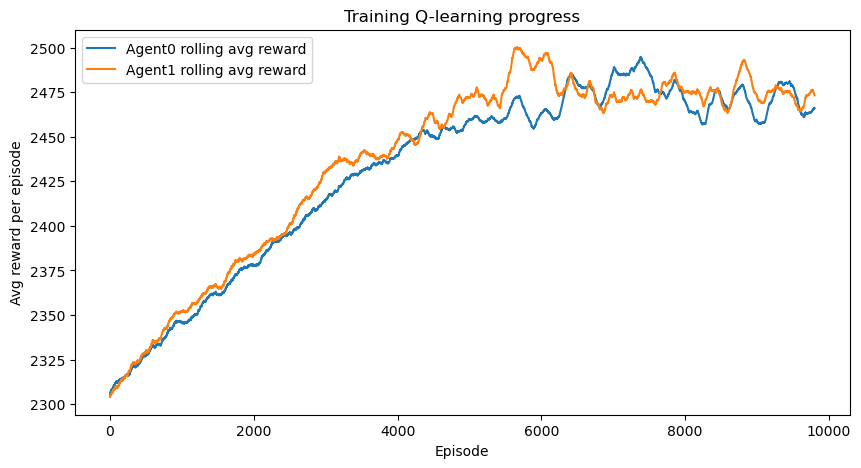

In [3]:
# Q learning for 2 agents

import numpy as np
import matplotlib.pyplot as plt

# --- Q-learning hyperparameters ---
alpha = 0.1 # learning rate
gamma = 0.95 # discount factor (how much future reward is valued)
# epsilon: exploration probability -> decays over time
epsilon_start = 1.0 # initial 100% prbability to explore at first (the agents choose causakl actions)
epsilon_min = 0.05 # minimum expoloration probability
epsilon_decay = 0.9995 # decay factor per episode
num_episodes = 10000
max_steps_per_episode = 50
seed = 42

np.random.seed(seed)

# --- Environment ---
env = CoffeeCapsuleMarketEnv2Agents(seed=seed)
num_prices = env.num_prices

# --- Q-tables: one per agent ---
# State = (own_prev_price, competitor_prev_price)
# Map this 2D state into a single index: own_prev * num_prices + comp_prev)
num_states = num_prices * num_prices
num_actions = num_prices

Q_agent0 = np.zeros((num_states, num_actions))
Q_agent1 = np.zeros((num_states, num_actions))

# --- Map (own_prev, comp_prev) -> unique Q-table index ---
def state_to_index(state_tuple):
    own_prev, comp_prev = state_tuple
    return own_prev * num_prices + comp_prev

# --- Epsilon-greedy action selection ---
def select_action(Q, state_index, epsilon):
    if np.random.rand() < epsilon:
        # Explore: random price index
        return np.random.randint(num_actions)
    else:
        # Exploit: choose action with max Q-value
        max_val = np.max(Q[state_index])
        candidates = np.where(Q[state_index] == max_val)[0]
        return np.random.choice(candidates)

# --- Training loop ---
epsilon = epsilon_start
episode_rewards_agent0 = []
episode_rewards_agent1 = []

for ep in range(num_episodes):

    # Reset environment: each agent starts with random previous prices
    state, _ = env.reset(seed=None)  # state = [(own_prev, comp_prev)_0, (own_prev, comp_prev)_1]
    total_r0 = 0.0
    total_r1 = 0.0

    for t in range(max_steps_per_episode):
        
        # Convert each agent's observation into state indices
        s0_index = state_to_index(state[0])
        s1_index = state_to_index(state[1])

        # Select actions using epsilon-greedy
        a0 = select_action(Q_agent0, s0_index, epsilon)
        a1 = select_action(Q_agent1, s1_index, epsilon)

        # Step in the environment
        next_state, rewards, _, _, info = env.step([a0, a1])
        r0, r1 = rewards
        total_r0 += r0
        total_r1 += r1

        ns0_index = state_to_index(next_state[0])
        ns1_index = state_to_index(next_state[1])

        # --- Q-learning update rule for each agent ---
        Q_agent0[s0_index, a0] += alpha * (r0 + gamma * np.max(Q_agent0[ns0_index]) - Q_agent0[s0_index, a0])
        Q_agent1[s1_index, a1] += alpha * (r1 + gamma * np.max(Q_agent1[ns1_index]) - Q_agent1[s1_index, a1])

        # Move to next state
        state = next_state

    # Track rewards for monitoring
    episode_rewards_agent0.append(total_r0)
    episode_rewards_agent1.append(total_r1)

    # Decay exploration
    epsilon = max(epsilon_min, epsilon * epsilon_decay)

    if (ep + 1) % 2000 == 0 or ep == 0:
        avg0 = np.mean(episode_rewards_agent0[-200:])
        avg1 = np.mean(episode_rewards_agent1[-200:])
        print(f"Ep {ep+1}/{num_episodes}  eps={epsilon:.4f}  avg_last200_rewards: agent0={avg0:.2f}, agent1={avg1:.2f}")

# --- Extract greedy policy (best action for each state)  ---
policy_agent0 = np.argmax(Q_agent0, axis=1)
policy_agent1 = np.argmax(Q_agent1, axis=1)

print("\nPolicy greedy agent0 (indice prezzi):", policy_agent0)
print("Policy greedy agent1:", policy_agent1)
print("Mapping indici -> prezzi reali:", env.prices)
print("Policy agent0 (prezzo reale):", [env.prices[a] for a in policy_agent0])
print("Policy agent1 (prezzo reale):", [env.prices[a] for a in policy_agent1])

# --- Policy evaluation function  ---
def evaluate_policy(policy0, policy1, env, episodes=500, steps=50):
    tot0, tot1 = 0.0, 0.0
    for ep in range(episodes):
        state, _ = env.reset()
        for t in range(steps):
            # Select greedy actions according to learned policies
            a0 = policy0[state_to_index(state[0])]
            a1 = policy1[state_to_index(state[1])]
            next_state, rewards, _, _, _ = env.step([int(a0), int(a1)])
            tot0 += rewards[0]
            tot1 += rewards[1]
            state = next_state
    return tot0 / episodes / steps, tot1 / episodes / steps

# Evaluate greedy policies
avg_r0, avg_r1 = evaluate_policy(policy_agent0, policy_agent1, env)
print(f"\nValutazione greedy (avg reward per step): agent0={avg_r0:.3f}, agent1={avg_r1:.3f}")

# --- Plot training progress ---
window = 200
rolling_avg0 = np.convolve(episode_rewards_agent0, np.ones(window)/window, mode='valid')
rolling_avg1 = np.convolve(episode_rewards_agent1, np.ones(window)/window, mode='valid')

plt.figure(figsize=(10,5))
plt.plot(rolling_avg0, label='Agent0 rolling avg reward')
plt.plot(rolling_avg1, label='Agent1 rolling avg reward')
plt.xlabel('Episode')
plt.ylabel('Avg reward per episode')
plt.legend()
plt.title('Training Q-learning progress')
plt.show()


## DQN ##

Aim: trains two Deep Q-Networks - one for each market competitor - in the 2-agent pricing environment.


Ep 1/10000  avg_rewards(last200): Agent0=2269.06, Agent1=2299.26
Ep 500/10000  avg_rewards(last200): Agent0=2331.81, Agent1=2330.58
Ep 1000/10000  avg_rewards(last200): Agent0=2362.49, Agent1=2361.09
Ep 1500/10000  avg_rewards(last200): Agent0=2389.04, Agent1=2386.68
Ep 2000/10000  avg_rewards(last200): Agent0=2406.85, Agent1=2406.56
Ep 2500/10000  avg_rewards(last200): Agent0=2421.76, Agent1=2422.38
Ep 3000/10000  avg_rewards(last200): Agent0=2435.81, Agent1=2436.29
Ep 3500/10000  avg_rewards(last200): Agent0=2446.55, Agent1=2446.45
Ep 4000/10000  avg_rewards(last200): Agent0=2454.34, Agent1=2453.89
Ep 4500/10000  avg_rewards(last200): Agent0=2460.23, Agent1=2461.24
Ep 5000/10000  avg_rewards(last200): Agent0=2465.20, Agent1=2464.41
Ep 5500/10000  avg_rewards(last200): Agent0=2468.43, Agent1=2468.56
Ep 6000/10000  avg_rewards(last200): Agent0=2471.03, Agent1=2470.97
Ep 6500/10000  avg_rewards(last200): Agent0=2472.64, Agent1=2472.73
Ep 7000/10000  avg_rewards(last200): Agent0=2471.17,

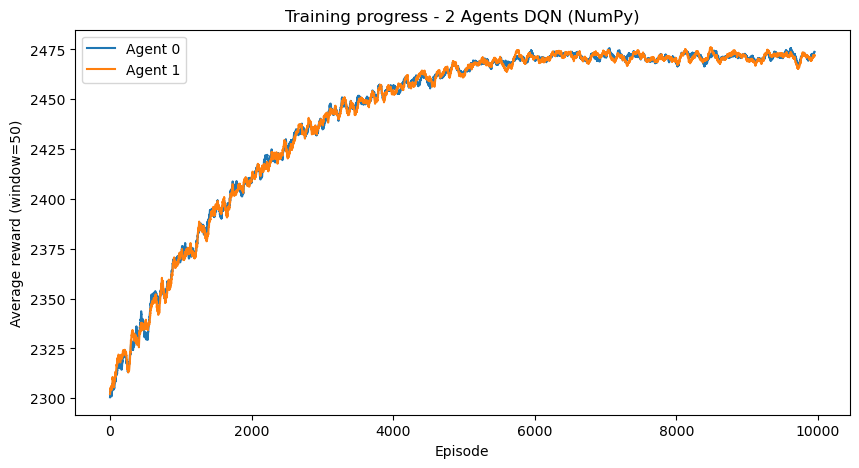

In [9]:
# DQN

import numpy as np
import random
from collections import deque
import matplotlib.pyplot as plt

# ====================================================
# HYPERPARAMETERS
# ====================================================
num_episodes = 10000
max_steps = 50
gamma = 0.95
epsilon_start = 1.0
epsilon_min = 0.05
epsilon_decay = 0.9995
alpha = 0.01   # learning rate rete
hidden_size = 32
buffer_size = 5000
batch_size = 32
seed = 42

np.random.seed(seed)
random.seed(seed)

# ====================================================
# ENV SETUP
# ====================================================
env = CoffeeCapsuleMarketEnv2Agents(seed=seed)
num_prices = env.num_prices
num_actions = num_prices
input_size = 2  

# ====================================================
# REPLAY BUFFER
# ====================================================
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    def push(self, s, a, r, s_next, d):
        self.buffer.append((s,a,r,s_next,d))
    def sample(self, n):
        batch = random.sample(self.buffer, n)
        s,a,r,s_next,d = zip(*batch)
        return np.array(s), np.array(a), np.array(r), np.array(s_next), np.array(d)
    def __len__(self):
        return len(self.buffer)

# ====================================================
# SIMPLE DQN (NumPy)
# ====================================================
class SimpleDQN:
    def __init__(self, input_size, output_size, hidden_size):
        self.W1 = np.random.randn(input_size, hidden_size) * 0.1
        self.b1 = np.zeros(hidden_size)
        self.W2 = np.random.randn(hidden_size, output_size) * 0.1
        self.b2 = np.zeros(output_size)
    
    def forward(self, x):
        x = np.array(x, dtype=float)
        self.z1 = x @ self.W1 + self.b1
        self.a1 = np.tanh(self.z1)
        self.z2 = self.a1 @ self.W2 + self.b2
        return self.z2  # Q-values
    
    def update(self, x, target, action, lr=0.01):
        q_values = self.forward(x)
        q = q_values[action]
        error = q - target
        # Backpropagation manuale
        dW2 = np.outer(self.a1, np.eye(len(q_values))[action]) * error
        db2 = np.eye(len(q_values))[action] * error
        da1 = self.W2[:, action] * error
        dz1 = da1 * (1 - self.a1**2)
        dW1 = np.outer(x, dz1)
        db1 = dz1
        # Gradient step
        self.W2 -= lr * dW2
        self.b2 -= lr * db2.sum(axis=0)
        self.W1 -= lr * dW1
        self.b1 -= lr * db1

# ====================================================
# Initialize 2 independent agents
# ====================================================
agents = []
for _ in range(2):
    agents.append({
        'net': SimpleDQN(input_size, num_actions, hidden_size),
        'buffer': ReplayBuffer(buffer_size)
    })

epsilon = epsilon_start
episode_rewards = [[], []]

# ====================================================
# TRAINING LOOP
# ====================================================
for ep in range(num_episodes):
    state, _ = env.reset()
    total_rewards = [0, 0]
    
    for t in range(max_steps):
        actions = []
        # Epsilon-greedy action selection for each agent
        for i, agent in enumerate(agents):
            if np.random.rand() < epsilon:
                a = np.random.randint(num_actions) # explore
            else:
                q_vals = agent['net'].forward(state[i]) # exploit
                a = int(np.argmax(q_vals)) 
            actions.append(a)
        
        # Step in environment
        next_state, rewards, done, truncated, _ = env.step(actions)
        
        # Store transitions and update networks
        for i, agent in enumerate(agents):
            s = np.array(state[i])
            s_next = np.array(next_state[i])
            agent['buffer'].push(s, actions[i], rewards[i], s_next, done)
            total_rewards[i] += rewards[i]

            # DQN update (only when buffer has enough data)
            if len(agent['buffer']) >= batch_size:
                s_b, a_b, r_b, s_next_b, d_b = agent['buffer'].sample(batch_size)
                
                for s, a, r, s_next, d in zip(s_b, a_b, r_b, s_next_b, d_b):
                    q_next = np.max(agent['net'].forward(s_next))
                    target = r + gamma * q_next * (1 - d)
                    agent['net'].update(s, target, a, lr=alpha)
        
        state = next_state
    
    for i in range(2):
        episode_rewards[i].append(total_rewards[i])
    
    epsilon = max(epsilon_min, epsilon * epsilon_decay) # decay exploration
    
    if (ep + 1) % 500 == 0 or ep == 0:
        avg_r = [np.mean(episode_rewards[i][-200:]) for i in range(2)]
        print(f"Ep {ep+1}/{num_episodes}  avg_rewards(last200): Agent0={avg_r[0]:.2f}, Agent1={avg_r[1]:.2f}")

# ====================================================
# RESULTS
# ====================================================
window = 50
plt.figure(figsize=(10,5))
for i, rewards in enumerate(episode_rewards):
    plt.plot(np.convolve(rewards, np.ones(window)/window, mode='valid'), label=f'Agent {i}')
plt.xlabel('Episode')
plt.ylabel('Average reward (window=50)')
plt.title('Training progress - 2 Agents DQN (NumPy)')
plt.legend()
plt.show()

## Comparison between Q-learning and DQN - Duopoly ##

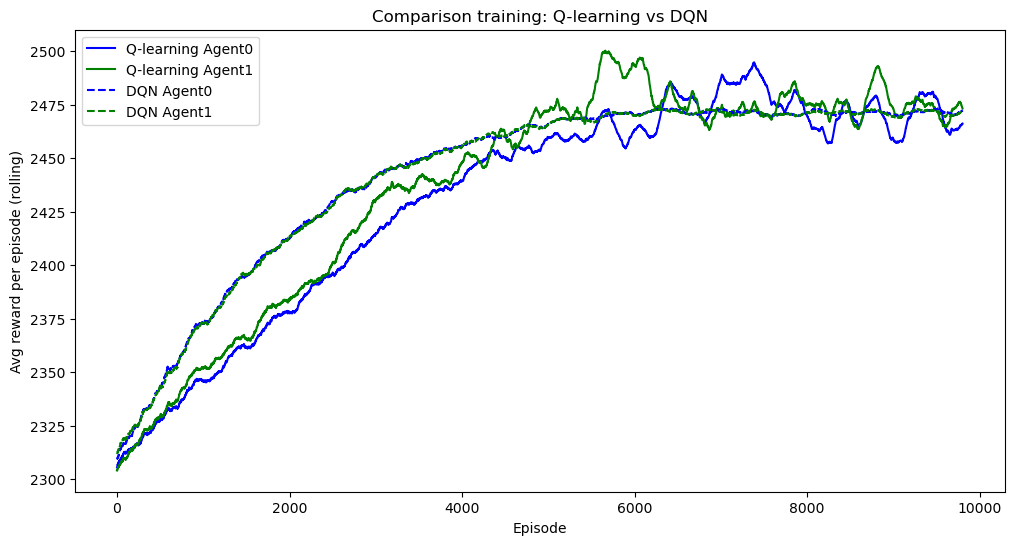

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# ====================================================
# Rolling averages
# ====================================================
window_q = 200   # Q-learning 
window_dqn = 200  # DQN 

rolling_q0 = np.convolve(episode_rewards_agent0, np.ones(window_q)/window_q, mode='valid')
rolling_q1 = np.convolve(episode_rewards_agent1, np.ones(window_q)/window_q, mode='valid')

rolling_dqn0 = np.convolve(episode_rewards[0], np.ones(window_dqn)/window_dqn, mode='valid')
rolling_dqn1 = np.convolve(episode_rewards[1], np.ones(window_dqn)/window_dqn, mode='valid')

# ====================================================
# Plot comparison
# ====================================================
plt.figure(figsize=(12,6))

plt.plot(rolling_q0, label='Q-learning Agent0', color='blue')
plt.plot(rolling_q1, label='Q-learning Agent1', color='green')

plt.plot(rolling_dqn0, '--', label='DQN Agent0', color='blue')
plt.plot(rolling_dqn1, '--', label='DQN Agent1', color='green')

plt.xlabel('Episode')
plt.ylabel('Avg reward per episode (rolling)')
plt.title('Comparison training: Q-learning vs DQN')
plt.legend()
plt.show()


## Environment with 3 agents - Discrete Oligopoly ##

In [3]:
# Environment with 3 agents - Oligopoly

!pip install gymnasium
import numpy as np
import gymnasium as gym
from gymnasium import spaces

class CoffeeCapsuleMarketEnv3Agents(gym.Env):
    metadata = {'render_modes': ['human']}
    
    def __init__(self, 
                 prices=[2.99, 3.48, 3.85, 3.99, 4.60, 4.85, 5.05, 5.45, 5.84, 5.99],
                 cost=0.5, a=20, b=1.8, c=0.5, seed=None):
        super().__init__()

        self.prices = prices
        self.num_prices = len(prices)
        self.cost = cost
        self.a = a
        self.b = b
        self.c = c
        self.num_agents = 3
        
        self.action_space = spaces.Discrete(self.num_prices)
        self.observation_space = spaces.MultiDiscrete([self.num_prices]*self.num_agents)

        self.state = [(0,0,0)] * self.num_agents
        self.done = False

        if seed is not None:
            np.random.seed(seed)

    def step(self, actions):
        prices = [self.prices[a] for a in actions]
        rewards = []
        quantities = []

        for i in range(self.num_agents):
            competitors = [prices[j] for j in range(self.num_agents) if j != i]
            avg_comp = np.mean(competitors)
            demand = self.a - self.b * prices[i] + self.c * (avg_comp - prices[i])
            demand = max(demand, 0)
            quantities.append(demand)
            rewards.append((prices[i] - self.cost) * demand)

        self.state = [
            (actions[i],
             actions[(i+1) % self.num_agents],
             actions[(i+2) % self.num_agents])
            for i in range(self.num_agents)
        ]

        return self.state, rewards, False, False, {'prices': prices, 'quantities': quantities}

    def reset(self, seed=None):
        if seed is not None:
            np.random.seed(seed)

        initial_actions = [np.random.randint(self.num_prices) for _ in range(self.num_agents)]

        self.state = [
            (initial_actions[i],
             initial_actions[(i+1) % self.num_agents],
             initial_actions[(i+2) % self.num_agents])
            for i in range(self.num_agents)
        ]

        return self.state, {}


## Q-learning

Ep 1/10000  eps=0.9995  avg_last200_rewards: agent0=2325.41, agent1=2286.99, agent2=2259.86
Ep 2000/10000  eps=0.3678  avg_last200_rewards: agent0=2336.36, agent1=2336.03, agent2=2335.26
Ep 4000/10000  eps=0.1353  avg_last200_rewards: agent0=2350.43, agent1=2348.64, agent2=2349.02
Ep 6000/10000  eps=0.0500  avg_last200_rewards: agent0=2349.39, agent1=2349.58, agent2=2348.26
Ep 8000/10000  eps=0.0500  avg_last200_rewards: agent0=2348.78, agent1=2349.02, agent2=2346.82
Ep 10000/10000  eps=0.0500  avg_last200_rewards: agent0=2350.50, agent1=2350.83, agent2=2349.52

Mapping index -> real prices: [2.99, 3.48, 3.85, 3.99, 4.6, 4.85, 5.05, 5.45, 5.84, 5.99]
Policy greedy agent0: (prezzi reali) [3.85, 3.85, 3.48, 3.85, 5.05, 5.05, 5.99, 3.99, 5.45, 4.85, 5.05, 5.84, 5.99, 3.85, 5.84, 4.85, 3.99, 5.99, 4.6, 4.6, 4.6, 3.99, 5.05, 5.05, 5.99, 4.85, 5.05, 4.6, 3.99, 5.45, 5.45, 3.99, 5.84, 5.99, 2.99, 5.45, 4.6, 3.48, 3.48, 4.85, 4.6, 4.85, 5.05, 5.84, 4.6, 5.45, 2.99, 5.99, 3.99, 4.85, 4.85, 4.6,

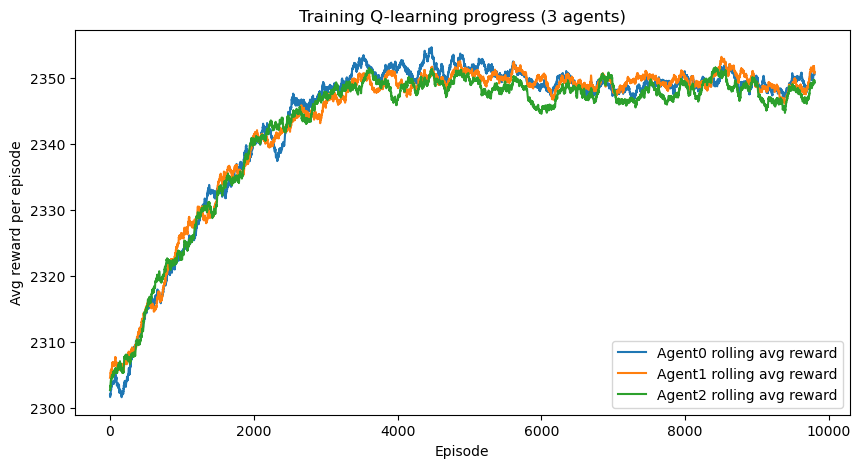

In [7]:
# Q learning with 3 agents

import numpy as np
import matplotlib.pyplot as plt

# --- Hyperparameters Q-learning ---
alpha = 0.1       # learning rate
gamma = 0.95      # discount factor
epsilon_start = 1.0
epsilon_min = 0.05
epsilon_decay = 0.9995
num_episodes = 10000
max_steps_per_episode = 50
seed = 42

np.random.seed(seed)

# --- Environment ---
env = CoffeeCapsuleMarketEnv3Agents(seed=seed)
num_prices = env.num_prices
num_agents = env.num_agents

# --- Q-tables ---
# State = (own_prev, comp1_prev, comp2_prev)
num_states = num_prices ** num_agents  # n^3 states
num_actions = num_prices

Q_tables = [np.zeros((num_states, num_actions)) for _ in range(num_agents)]

# --- Mapping (own_prev, comp1_prev, comp2_prev) ---
def state_to_index(state_tuple):
    # state_tuple = (own_prev, comp1_prev, comp2_prev)
    own_prev, comp1_prev, comp2_prev = state_tuple
    return own_prev * (num_prices ** 2) + comp1_prev * num_prices + comp2_prev

# --- Epsilon-greedy action selection ---
def select_action(Q, state_index, epsilon):
    if np.random.rand() < epsilon:
        return np.random.randint(num_actions)
    else:
        max_val = np.max(Q[state_index])
        candidates = np.where(Q[state_index] == max_val)[0]
        return np.random.choice(candidates)

# --- Training loop ---
epsilon = epsilon_start
episode_rewards_q = [[] for _ in range(num_agents)] # Renamed for clarity

for ep in range(num_episodes):
    state, _ = env.reset(seed=None)
    totals = [0.0] * num_agents

    for t in range(max_steps_per_episode):
        state_indices = [state_to_index(state[i]) for i in range(num_agents)]

        # Epsilon-greedy for each agent
        actions = [select_action(Q_tables[i], state_indices[i], epsilon) for i in range(num_agents)]

        # Step in environment
        next_state, rewards, _, _, info = env.step(actions)
        for i in range(num_agents):
            totals[i] += rewards[i]

        # Update Q-table for each agent
        next_indices = [state_to_index(next_state[i]) for i in range(num_agents)]
        for i in range(num_agents):
            Q_tables[i][state_indices[i], actions[i]] += alpha * (
                rewards[i] + gamma * np.max(Q_tables[i][next_indices[i]]) - Q_tables[i][state_indices[i], actions[i]]
            )

        state = next_state

    # Save rewards and update epsilon
    for i in range(num_agents):
        episode_rewards_q[i].append(totals[i]) # Renamed
    epsilon = max(epsilon_min, epsilon * epsilon_decay)

    if (ep + 1) % 2000 == 0 or ep == 0:
        avgs = [np.mean(r[-200:]) for r in episode_rewards_q] # Renamed
        print(f"Ep {ep+1}/{num_episodes}  eps={epsilon:.4f}  avg_last200_rewards: " +
              ", ".join([f"agent{i}={avgs[i]:.2f}" for i in range(num_agents)]))

# --- Policy greedy ---
policies_q = [np.argmax(Q, axis=1) for Q in Q_tables] # Renamed

print("\nMapping index -> real prices:", env.prices)
for i in range(num_agents):
    print(f"Policy greedy agent{i}: (prezzi reali) {[env.prices[a] for a in policies_q[i]]}") # Renamed

# --- Evaluation policy greedy ---
def evaluate_policy(policies, env, episodes=500, steps=50):
    num_agents = len(policies)
    totals = np.zeros(num_agents)
    for ep in range(episodes):
        state, _ = env.reset()
        for t in range(steps):
            # Ensure the state_to_index logic is consistent if state is a tuple here.
            # The original code's state_to_index handles this.
            actions = [policies[i][state_to_index(state[i])] for i in range(num_agents)]
            next_state, rewards, _, _, _ = env.step([int(a) for a in actions])
            totals += rewards
            state = next_state
    return totals / episodes / steps

avg_rewards_q = evaluate_policy(policies_q, env) # Renamed
for i, r in enumerate(avg_rewards_q):
    print(f"Evaluation greedy (avg reward per step) agent{i}={r:.3f}")

window = 200
plt.figure(figsize=(10,5))
for i in range(num_agents):
    rolling_avg = np.convolve(episode_rewards_q[i], np.ones(window)/window, mode='valid') # Renamed
    plt.plot(rolling_avg, label=f'Agent{i} rolling avg reward')
plt.xlabel('Episode')
plt.ylabel('Avg reward per episode')
plt.legend()
plt.title('Training Q-learning progress (3 agents)')
plt.show()

## DQN ##

Ep 1/10000  avg_rewards(last200): Agent0=2320.24, Agent1=2300.34, Agent2=2260.96
Ep 500/10000  avg_rewards(last200): Agent0=2327.88, Agent1=2328.56, Agent2=2328.19
Ep 1000/10000  avg_rewards(last200): Agent0=2360.46, Agent1=2361.50, Agent2=2361.78
Ep 1500/10000  avg_rewards(last200): Agent0=2387.83, Agent1=2385.67, Agent2=2385.85
Ep 2000/10000  avg_rewards(last200): Agent0=2405.17, Agent1=2407.34, Agent2=2406.79
Ep 2500/10000  avg_rewards(last200): Agent0=2424.34, Agent1=2422.78, Agent2=2423.22
Ep 3000/10000  avg_rewards(last200): Agent0=2435.92, Agent1=2435.49, Agent2=2437.43
Ep 3500/10000  avg_rewards(last200): Agent0=2445.77, Agent1=2446.56, Agent2=2445.82
Ep 4000/10000  avg_rewards(last200): Agent0=2454.38, Agent1=2454.68, Agent2=2455.29
Ep 4500/10000  avg_rewards(last200): Agent0=2460.65, Agent1=2459.63, Agent2=2460.22
Ep 5000/10000  avg_rewards(last200): Agent0=2464.31, Agent1=2464.91, Agent2=2464.56
Ep 5500/10000  avg_rewards(last200): Agent0=2469.03, Agent1=2468.93, Agent2=2468

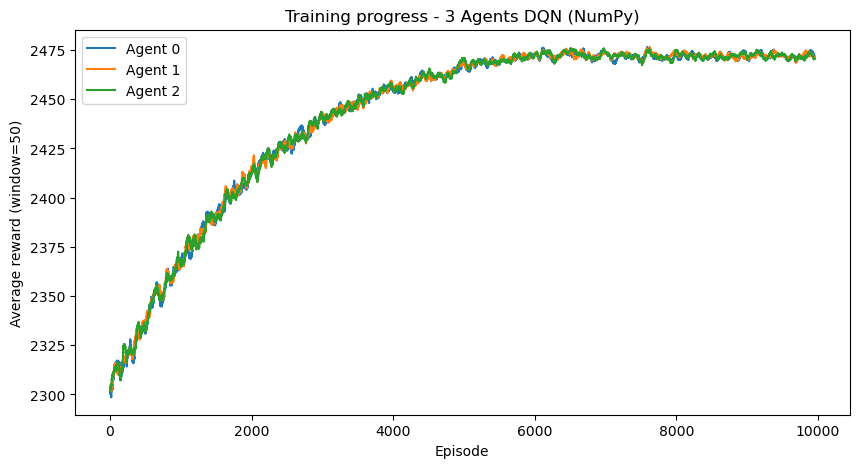

In [11]:
# DQN 

import numpy as np
import random
from collections import deque
import matplotlib.pyplot as plt

# ====================================================
# HYPERPARAMETERS
# ====================================================
num_episodes = 10000
max_steps = 50
gamma = 0.95
epsilon_start = 1.0
epsilon_min = 0.05
epsilon_decay = 0.9995
alpha = 0.01
hidden_size = 32
buffer_size = 5000
batch_size = 32
seed = 42

np.random.seed(seed)
random.seed(seed)

# ====================================================
# ENV SETUP
# ====================================================
env = CoffeeCapsuleMarketEnv3Agents(seed=seed)
num_prices = env.num_prices
num_agents = env.num_agents
num_actions = num_prices
input_size = num_agents  

# ====================================================
# REPLAY BUFFER
# ====================================================
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    def push(self, s, a, r, s_next, d):
        self.buffer.append((s,a,r,s_next,d))
    def sample(self, n):
        batch = random.sample(self.buffer, n)
        s,a,r,s_next,d = zip(*batch)
        return np.array(s), np.array(a), np.array(r), np.array(s_next), np.array(d)
    def __len__(self):
        return len(self.buffer)

# ====================================================
# SIMPLE DQN (NumPy)
# ====================================================
class SimpleDQN:
    def __init__(self, input_size, output_size, hidden_size):
        self.W1 = np.random.randn(input_size, hidden_size) * 0.1
        self.b1 = np.zeros(hidden_size)
        self.W2 = np.random.randn(hidden_size, output_size) * 0.1
        self.b2 = np.zeros(output_size)

    def forward(self, x):
        x = np.array(x, dtype=float)
        self.z1 = x @ self.W1 + self.b1
        self.a1 = np.tanh(self.z1)
        self.z2 = self.a1 @ self.W2 + self.b2
        return self.z2  # Q-values

    def update(self, x, target, action, lr=0.01):
        q_values = self.forward(x)
        q = q_values[action]
        error = q - target
        # Gradients
        dW2 = np.outer(self.a1, np.eye(len(q_values))[action]) * error
        db2 = np.eye(len(q_values))[action] * error
        da1 = self.W2[:, action] * error
        dz1 = da1 * (1 - self.a1**2)
        dW1 = np.outer(x, dz1)
        db1 = dz1
        # Update
        self.W2 -= lr * dW2
        self.b2 -= lr * db2.sum(axis=0)
        self.W1 -= lr * dW1
        self.b1 -= lr * db1

# ====================================================
# AGENTS
# ====================================================
agents = []
for _ in range(num_agents):
    agents.append({
        'net': SimpleDQN(input_size, num_actions, hidden_size),
        'buffer': ReplayBuffer(buffer_size)
    })

epsilon = epsilon_start
episode_rewards_dqn = [[] for _ in range(num_agents)] # Renamed for clarity

# ====================================================
# TRAINING LOOP
# ====================================================
for ep in range(num_episodes):
    state, _ = env.reset()
    total_rewards = [0.0] * num_agents

    for t in range(max_steps):
        actions = []
        # Epsilon-greedy
        for i, agent in enumerate(agents):
            if np.random.rand() < epsilon:
                a = np.random.randint(num_actions)
            else:
                q_vals = agent['net'].forward(state[i])
                a = int(np.argmax(q_vals))
            actions.append(a)

        # Step
        next_state, rewards, done, truncated, _ = env.step(actions)

        for i, agent in enumerate(agents):
            s = np.array(state[i])
            s_next = np.array(next_state[i])
            agent['buffer'].push(s, actions[i], rewards[i], s_next, done)
            total_rewards[i] += rewards[i]

            if len(agent['buffer']) >= batch_size:
                s_b, a_b, r_b, s_next_b, d_b = agent['buffer'].sample(batch_size)
                for s, a, r, s_next, d in zip(s_b, a_b, r_b, s_next_b, d_b):
                    q_next = np.max(agent['net'].forward(s_next))
                    target = r + gamma * q_next * (1 - d)
                    agent['net'].update(s, target, a, lr=alpha)

        state = next_state

    for i in range(num_agents):
        episode_rewards_dqn[i].append(total_rewards[i]) # Renamed

    epsilon = max(epsilon_min, epsilon * epsilon_decay)

    if (ep + 1) % 500 == 0 or ep == 0:
        avg_r = [np.mean(episode_rewards_dqn[i][-200:]) for i in range(num_agents)] # Renamed
        print(f"Ep {ep+1}/{num_episodes}  avg_rewards(last200): " +
              ", ".join([f"Agent{i}={avg_r[i]:.2f}" for i in range(num_agents)]))

# ====================================================
# RESULTS
# ====================================================
window = 50
plt.figure(figsize=(10,5))
for i, rewards in enumerate(episode_rewards_dqn): # Renamed
    plt.plot(np.convolve(rewards, np.ones(window)/window, mode='valid'), label=f'Agent {i}')
plt.xlabel('Episode')
plt.ylabel('Average reward (window=50)')
plt.title('Training progress - 3 Agents DQN (NumPy)')
plt.legend()
plt.show()

## Comparison between Q-learning and DQN - Discrete Oligopoly

Agente 0: 15.30% delle azioni Q-learning e DQN coincidono
Agente 1: 12.40% delle azioni Q-learning e DQN coincidono
Agente 2: 11.10% delle azioni Q-learning e DQN coincidono

Reward medio per step:
Agente0: Q-learning=46.803, DQN=50.096
Agente1: Q-learning=47.146, DQN=50.096
Agente2: Q-learning=47.060, DQN=49.451


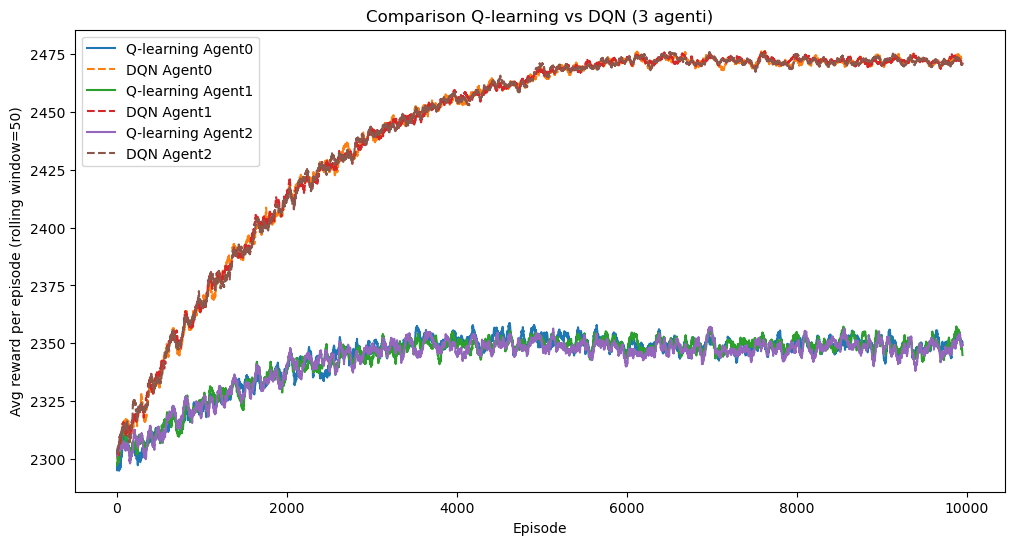

In [13]:
import numpy as np
import matplotlib.pyplot as plt

def state_to_index(state_tuple):
    own_prev, comp1_prev, comp2_prev = state_tuple
    # Assuming env.num_prices is accessible from the global scope (defined in previous cells)
    return own_prev * (env.num_prices ** 2) + comp1_prev * env.num_prices + comp2_prev

# Define policies_dqn based on the trained DQN networks
policies_dqn = []
for i in range(env.num_agents):
    dqn_policy = np.zeros(env.num_prices ** env.num_agents, dtype=int)
    # Iterate over all possible states (own, comp1, comp2) to build the policy
    for own_p_idx in range(env.num_prices):
        for comp1_p_idx in range(env.num_prices):
            for comp2_p_idx in range(env.num_prices):
                agent_obs_tuple = (own_p_idx, comp1_p_idx, comp2_p_idx)
                # The DQN network expects a direct state observation, not an index
                q_vals = agents[i]['net'].forward(agent_obs_tuple)
                greedy_action = np.argmax(q_vals)
                dqn_policy[state_to_index(agent_obs_tuple)] = greedy_action
    policies_dqn.append(dqn_policy)

def compare_policies(policy1, policy2):
    policy1 = np.array(policy1)
    policy2 = np.array(policy2)
    identical = np.sum(policy1 == policy2)
    total = len(policy1)
    return identical / total * 100

for i in range(3):
    perc_identical = compare_policies(policies_q[i], policies_dqn[i])
    print(f"Agente {i}: {perc_identical:.2f}% delle azioni Q-learning e DQN coincidono")

def evaluate_policy(policies, env, episodes=500, steps=50):
    num_agents = len(policies)
    totals = np.zeros(num_agents)
    for ep in range(episodes):
        state, _ = env.reset()
        for t in range(steps):
            # The state_to_index function defined above is used here.
            actions = [policies[i][state_to_index(state[i])] for i in range(num_agents)]
            next_state, rewards, _, _, _ = env.step([int(a) for a in actions])
            totals += rewards
            state = next_state
    return totals / episodes / steps

avg_rewards_q = evaluate_policy(policies_q, env)
avg_rewards_dqn = evaluate_policy(policies_dqn, env)

print("\nReward medio per step:")
for i in range(3):
    print(f"Agente{i}: Q-learning={avg_rewards_q[i]:.3f}, DQN={avg_rewards_dqn[i]:.3f}")

# --- Plot rolling rewards ---
window = 50
plt.figure(figsize=(12,6))

for i in range(3):
    rolling_q = np.convolve(episode_rewards_q[i], np.ones(window)/window, mode='valid')
    rolling_dqn = np.convolve(episode_rewards_dqn[i], np.ones(window)/window, mode='valid')
    plt.plot(rolling_q, label=f'Q-learning Agent{i}')
    plt.plot(rolling_dqn, '--', label=f'DQN Agent{i}')

plt.xlabel('Episode')
plt.ylabel(f'Avg reward per episode (rolling window={window})')
plt.title('Comparison Q-learning vs DQN (3 agenti)')
plt.legend()
plt.show()